# Introduction

Here I'm checking if the way I am calculating gradients using keras is correct. I'm testing it on a vanilla
policy gradients, to keep things simple

In [21]:
import numpy as np
import tensorflow as tf
from collections import deque
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras import backend as K
from keras.utils import to_categorical


class PolicyAgent:
    """ RL agent with deep policy network """
    
    def __init__(self,num_states, num_actions):
        self.num_states = num_states
        self.num_actions = num_actions
        self.actions = range(num_actions)
        self.learning_rate = 0.01
        self.gamma = 0.99
        
        #These will store the samples from which the agent will learn
        self.states = []
        self.action_samples = []
        self.rewards = []
        
        self.model = self._make_model()
        self._make_train_function()

        
    def _make_model(self):
        
        # Neural Net
        model = Sequential()
        model.add(Dense(10, input_dim=self.num_states, activation='relu'))
        model.add(Dense(10, activation='relu'))
        model.add(Dense(10, activation='relu'))
        model.add(Dense(self.num_actions, activation='softmax'))
        return model
    
    
    def _make_train_function(self):
        """
        Keras doesn't directly take a loss function (usually, input and labels)
        So have to make my own. Have to use the keras 'functional API' for this
        """
        
        #Inputs -- call these 'holders' to remember
        state_holder = self.model.input
        action_onehot_placeholder = K.placeholder(name='action_onehot',shape=(None,self.num_actions))
        discounted_return_placeholder = K.placeholder(name='discounted_return',shape=(None,))
        
        #Loss
        prob_placeholder = self.model.output  #output has the same structure, so copy it
        action_prob = K.sum(prob_placeholder*action_onehot_placeholder,axis=1)
        log_action_prob = K.log(action_prob)
        #loss_vec = -log_action_prob*discounted_return_placeholder
        loss_vec = -log_action_prob*K.stop_gradient(discounted_return_placeholder)  #I only want gradient on the log(pi) --
        loss = K.mean(loss_vec)                                                     # -- this is a hack to get keras working 
                                                                                    #I think!        
        #Doing the 'training' -- get the updates, this is the way keras works
        adam = Adam()
        pars = self.model.trainable_weights
        updates = adam.get_updates(params=pars, loss=loss)
                
        #Defintion of function -- this takes the input and applies the 
        #updates; the syntax is weird!
        self.train = K.function(inputs=[state_holder,action_onehot_placeholder,discounted_return_placeholder],
                                outputs=[],updates = updates)

    
    def remember(self, state, action, reward):
        self.states.append(state)
        self.action_samples.append(action)
        self.rewards.append(reward)
        

    def act(self, state):
        """ Choose action according to softmax """
        
        probs =  self.model.predict(state)[0]
        action = np.random.choice(self.actions, p=probs)
        return action
    
        

    def learn(self):
        """
        Does the policy gradient step
        """
        
        S = np.array(self.states)    #2D array, (num_samples,state_dim)
        A = np.array(self.action_samples)   #1D array, (num_samples,)
        R = np.array(self.rewards)   #1D array, (num_samples,)
        
        #Prepare data
        A_onehot = to_categorical(A,self.num_actions)
        discount_return = self.compute_discount_return(R)
        R_discounted = self.compute_discount_return(R)
        
        #Train
        self.train([S,A_onehot,R_discounted])
        
        #Erase memory
        self.states = []
        self.action_samples = []
        self.rewards = []
        
        
        
    def compute_discount_return(self,R):
        """
        Input:
        R = 1D array, list of rewards
        
        Output:
        discouted R, 1D 
        
        """
        R_discounted = np.zeros_like(R)
        running_total = 0
        for t in reversed(range(len(R_discounted))):
            running_total = running_total*self.gamma + R[t]
            R_discounted[t] = running_total
            
        #Norm rewards
        R_discounted -= np.mean(R_discounted)
        R_discounted /= np.std(R_discounted)
        
        return R_discounted
        

    def load(self, name):
        self.model.load_weights(name)

    def save(self, name):
        self.model.save_weights(name)

/home/kokeeffe/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [27]:
import numpy as np
import tensorflow as tf
from collections import deque
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras import backend as K
from keras.utils import to_categorical


class PolicyAgent1:
    """ RL agent with deep policy network """
    
    def __init__(self,num_states, num_actions):
        self.num_states = num_states
        self.num_actions = num_actions
        self.actions = range(num_actions)
        self.learning_rate = 0.01
        self.gamma = 0.99
        
        #These will store the samples from which the agent will learn
        self.states = []
        self.action_samples = []
        self.rewards = []
        
        self.model = self._make_model()
        self._make_train_function()

        
    def _make_model(self):
        
        # Neural Net
        model = Sequential()
        model.add(Dense(10, input_dim=self.num_states, activation='relu'))
        model.add(Dense(10, activation='relu'))
        model.add(Dense(10, activation='relu'))
        model.add(Dense(self.num_actions, activation='softmax'))
        return model
    
    
    def _make_train_function(self):
        """
        Keras doesn't directly take a loss function (usually, input and labels)
        So have to make my own. Have to use the keras 'functional API' for this
        """
        
        #Inputs -- call these 'holders' to remember
        state_holder = self.model.input
        action_onehot_placeholder = K.placeholder(name='action_onehot',shape=(None,self.num_actions))
        discounted_return_placeholder = K.placeholder(name='discounted_return',shape=(None,))
        
        #Loss -- grad log pi
        prob_placeholder = self.model.output  #output has the same structure, so copy it
        action_prob = K.sum(prob_placeholder*action_onehot_placeholder,axis=1)
        log_action_prob = K.log(action_prob)
        pars = self.model.trainable_weights
        grads = tf.gradients(log_action_prob, pars, -discounted_return_placeholder)
        
     
        #Doing the 'training' -- get the updates, this is the way keras works
        adam = Adam(self.learning_rate)
        loss = grads #placeholder
        updates = adam.get_updates(params=pars, loss=loss, grads = grads)
                
        #Defintion of function -- this takes the input and applies the 
        #updates; the syntax is weird!
        self.train = K.function(inputs=[state_holder,action_onehot_placeholder,discounted_return_placeholder],
                                outputs=[],updates = updates)

    
    def remember(self, state, action, reward):
        self.states.append(state)
        self.action_samples.append(action)
        self.rewards.append(reward)
        

    def act(self, state):
        """ Choose action according to softmax """
        
        probs =  self.model.predict(state)[0]
        action = np.random.choice(self.actions, p=probs)
        return action
    
        

    def learn(self):
        """
        Does the policy gradient step
        """
        
        S = np.array(self.states)    #2D array, (num_samples,state_dim)
        A = np.array(self.action_samples)   #1D array, (num_samples,)
        R = np.array(self.rewards)   #1D array, (num_samples,)
        
        #Prepare data
        A_onehot = to_categorical(A,self.num_actions)
        discount_return = self.compute_discount_return(R)
        R_discounted = self.compute_discount_return(R)
        
        #Train
        self.train([S,A_onehot,R_discounted])
        
        #Erase memory
        self.states = []
        self.action_samples = []
        self.rewards = []
        
        
        
    def compute_discount_return(self,R):
        """
        Input:
        R = 1D array, list of rewards
        
        Output:
        discouted R, 1D 
        
        """
        R_discounted = np.zeros_like(R)
        running_total = 0
        for t in reversed(range(len(R_discounted))):
            running_total = running_total*self.gamma + R[t]
            R_discounted[t] = running_total
            
        #Norm rewards
        R_discounted -= np.mean(R_discounted)
        R_discounted /= np.std(R_discounted)
        
        return R_discounted
        

    def load(self, name):
        self.model.load_weights(name)

    def save(self, name):
        self.model.save_weights(name)

### Main

WARN: gym.spaces.Box autodetected dtype as <type 'numpy.float32'>. Please provide explicit dtype.
(episode, score) = (0, 19.0)
(episode, score) = (50, 27.0)
(episode, score) = (100, 20.0)
(episode, score) = (150, 21.0)
(episode, score) = (200, 6.0)
(episode, score) = (250, 1.0)
(episode, score) = (300, 51.0)
(episode, score) = (350, 2.0)
(episode, score) = (400, 4.0)
(episode, score) = (450, 12.0)
(episode, score) = (500, 28.0)
(episode, score) = (550, 14.0)
(episode, score) = (600, 7.0)
(episode, score) = (650, 31.0)
(episode, score) = (700, 7.0)
(episode, score) = (750, 46.0)
(episode, score) = (800, 152.0)
(episode, score) = (850, 156.0)
(episode, score) = (900, 182.0)
(episode, score) = (950, 152.0)


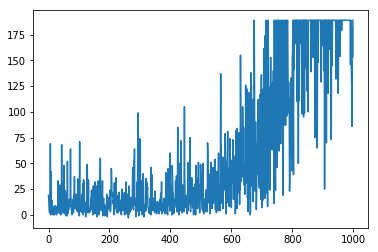

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import gym
%matplotlib inline

EPISODES = 1000

env = gym.make('CartPole-v0')
num_states = env.observation_space.shape[0]
num_actions = env.action_space.n
agent = PolicyAgent(num_states, num_actions)
agent.gamma = 0.999
# agent.load("./save/cartpole-dqn.h5")
done = False

scores = []

for e in range(EPISODES):
    state = env.reset()
    state = np.reshape(state, [1, num_states])
    reward_sum = 0
    for time in range(500):
        # env.render()
        action = agent.act(state)
        next_state, reward, done, _ = env.step(action)
        reward = reward if not done else -10
        reward_sum += reward
        next_state = np.reshape(next_state, [1, num_states])
        agent.remember(state[0], action, reward)
        state = next_state
        if done:
            break
    
    #Learn & print results
    agent.learn()
    scores.append(reward_sum)
    if e % 50 == 0:
        print '(episode, score) = ' + str((e,reward_sum))
        
plt.plot(scores)

WARN: gym.spaces.Box autodetected dtype as <type 'numpy.float32'>. Please provide explicit dtype.
(episode, score) = (0, 1.0)
(episode, score) = (50, 29.0)
(episode, score) = (100, 104.0)
(episode, score) = (150, 61.0)
(episode, score) = (200, 189.0)
(episode, score) = (250, 189.0)
(episode, score) = (300, 150.0)
(episode, score) = (350, 189.0)
(episode, score) = (400, 189.0)
(episode, score) = (450, 189.0)
(episode, score) = (500, 189.0)
(episode, score) = (550, 4.0)
(episode, score) = (600, -1.0)
(episode, score) = (650, 93.0)
(episode, score) = (700, 40.0)
(episode, score) = (750, 18.0)
(episode, score) = (800, 35.0)
(episode, score) = (850, 54.0)
(episode, score) = (900, 76.0)
(episode, score) = (950, 34.0)


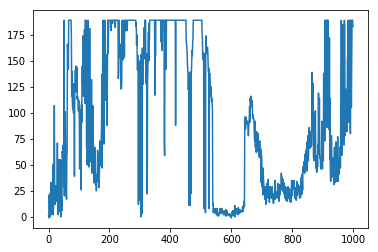

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import gym
%matplotlib inline

EPISODES = 1000

env = gym.make('CartPole-v0')
num_states = env.observation_space.shape[0]
num_actions = env.action_space.n
agent = PolicyAgent1(num_states, num_actions)
agent.gamma = 0.999
# agent.load("./save/cartpole-dqn.h5")
done = False

scores = []

for e in range(EPISODES):
    state = env.reset()
    state = np.reshape(state, [1, num_states])
    reward_sum = 0
    for time in range(500):
        # env.render()
        action = agent.act(state)
        next_state, reward, done, _ = env.step(action)
        reward = reward if not done else -10
        reward_sum += reward
        next_state = np.reshape(next_state, [1, num_states])
        agent.remember(state[0], action, reward)
        state = next_state
        if done:
            break
    
    #Learn & print results
    agent.learn()
    scores.append(reward_sum)
    if e % 50 == 0:
        print '(episode, score) = ' + str((e,reward_sum))
        
plt.plot(scores)